# Import necessary libraries and dataset

In [5]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import yfinance as yf

In [18]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

In [17]:
!pip install statsmodels

1488.42s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 69.6 MB/s eta 0:00:00


## Get Stock price details from Yahoo finance

In [7]:
sharesList = ['JPM', 'BATAINDIA.NS']
start = datetime.datetime(2020, 1, 1)
end = datetime.datetime(2025, 4, 1)

In [8]:
df_complete = yf.download(sharesList, start= start, end= end, progress=False)

YF.download() has changed argument auto_adjust default to True


In [9]:
df_complete.Close.head()

Ticker,BATAINDIA.NS,JPM
Date,,
2020-01-01,1644.539185,NaN
2020-01-02,1649.910156,120.733551
2020-01-03,1639.639282,119.140327
2020-01-06,1606.141846,119.045570
2020-01-07,1617.213501,117.021736


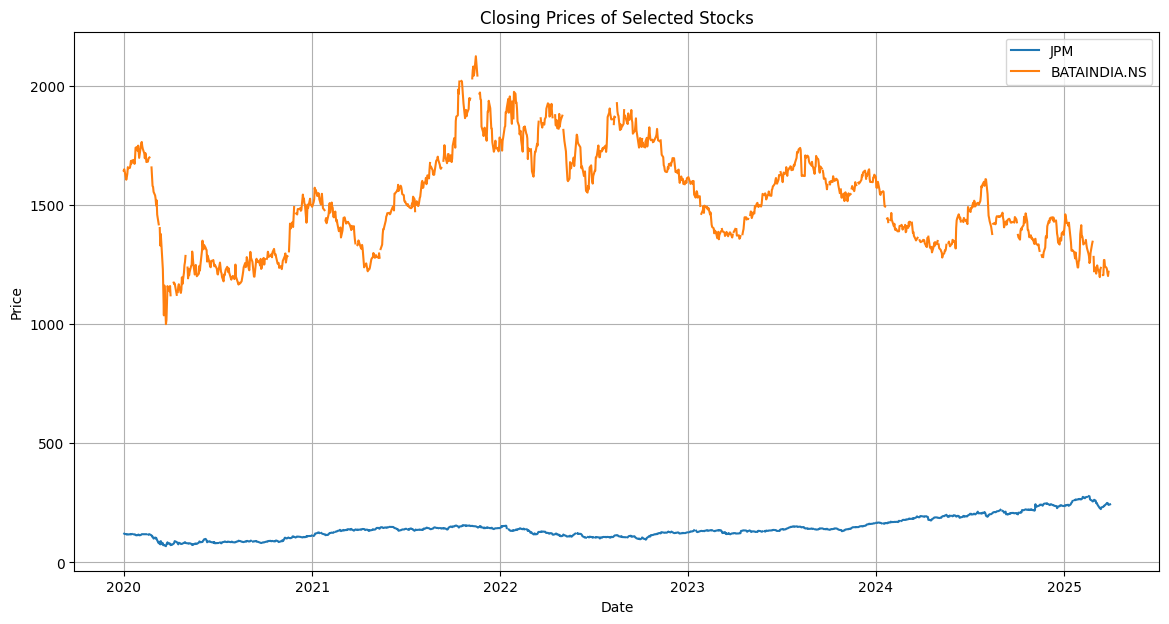

In [10]:
# Plot the closing prices
plt.figure(figsize=(14, 7))
for share in sharesList:
    plt.plot(df_complete['Close'][share], label=share)
plt.title('Closing Prices of Selected Stocks')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()

## Handle missing data for missing days

In [25]:
# Find out the missing business days in df_complete
df_complete.Close.asfreq('d').isna().sum()

Ticker
BATAINDIA.NS    617
JPM             599
dtype: int64

In [40]:
# Add the missing days
df_complete = df_complete.asfreq('d')
df_complete_alldays = df_complete.asfreq('d')

In [41]:
df_complete_alldays.head()

Price             Close                     High                      Low  \
Ticker     BATAINDIA.NS         JPM BATAINDIA.NS         JPM BATAINDIA.NS   
Date                                                                        
2020-01-01  1644.539185         NaN  1662.819078         NaN  1642.843057   
2020-01-02  1649.910156  120.733551  1657.495455  120.742117  1632.195484   
2020-01-03  1639.639282  119.140327  1655.799189  119.906807  1630.263769   
2020-01-04          NaN         NaN          NaN         NaN          NaN   
2020-01-05          NaN         NaN          NaN         NaN          NaN   

Price                          Open                   Volume              
Ticker             JPM BATAINDIA.NS         JPM BATAINDIA.NS         JPM  
Date                                                                      
2020-01-01         NaN  1650.428355         NaN     214199.0         NaN  
2020-01-02  119.167582  1647.083354  119.621112     269100.0  10803700.0  
2020-01-03  118.055203  1650.004222  118.416911     233227.0  10386800.0  
2020-01-04         NaN          NaN         NaN          NaN         NaN  
2020-01-05         NaN          NaN         NaN          NaN         NaN

# EDA

## Trend Analysis

In [42]:
# Create a function to plot Close prices of a selected stock
def plot_stock_prices(stock_symbol):
    plt.figure(figsize=(14, 7))
    plt.plot(df_complete_alldays['Close'][stock_symbol], label=stock_symbol)
    plt.title(f'Closing Prices of {stock_symbol}')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid()
    plt.show()

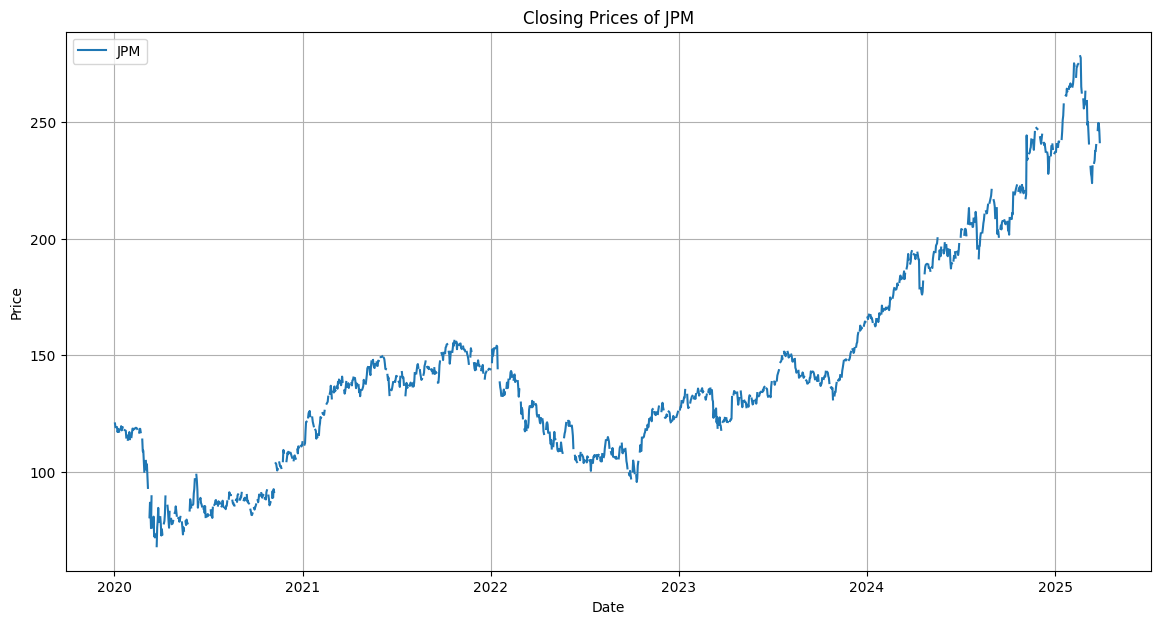

In [43]:
# Plot stocl price of JPM
plot_stock_prices('JPM')

## Interpolate missing values

In [44]:
# Interpolate the missing values
df_complete_alldays['Close'] = df_complete_alldays['Close'].interpolate(method='linear')


In [45]:
df_complete_alldays['Close'].isna().sum()

Ticker
BATAINDIA.NS    0
JPM             1
dtype: int64

In [46]:
# Print the date when JPM close price was NaN
df_complete_alldays[df_complete_alldays['Close']=='NaN'].index[0]

Timestamp('2020-01-01 00:00:00')

In [47]:
# drop first row
df_complete_alldays.drop(df_complete_alldays.index[0], inplace=True)

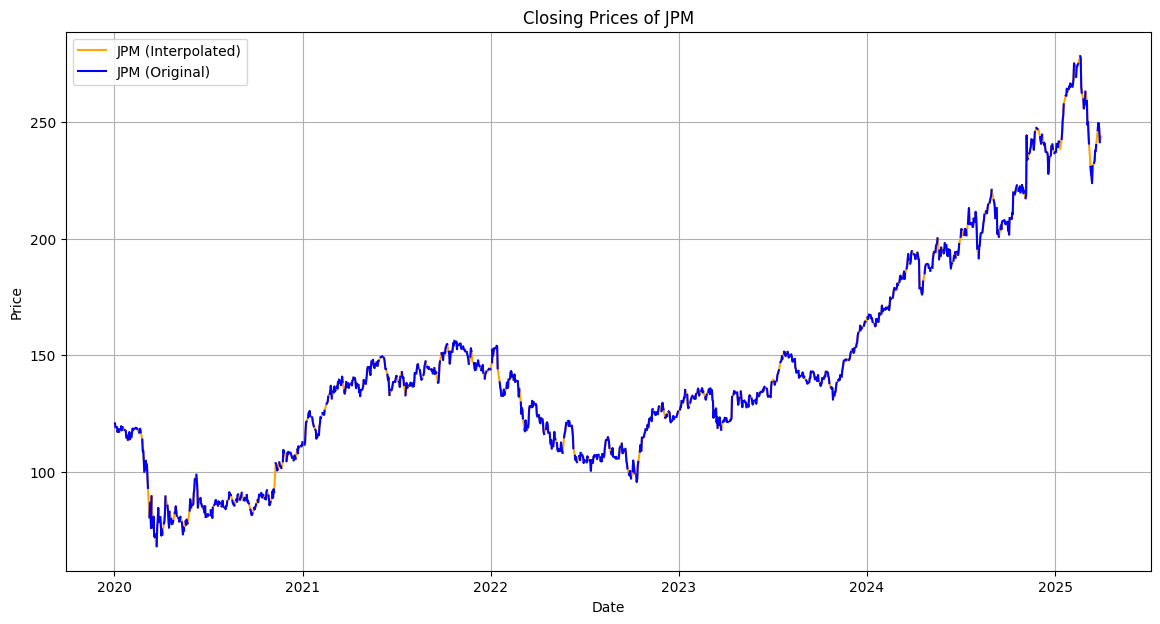

In [51]:
# Plot Close price for JPM from df_complete_alldays and df_complete
plt.figure(figsize=(14, 7))

plt.plot(df_complete_alldays['Close']['JPM'], label='JPM (Interpolated)', color='orange')
plt.plot(df_complete['Close']['JPM'], label='JPM (Original)', color='blue')

plt.title('Closing Prices of JPM')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()

## Seasonality check

In [52]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [57]:
# Decompose the time series
def decompose_stock_prices(stock_symbol):
    stock_data = df_complete_alldays['Close'][stock_symbol]
    decomposition = seasonal_decompose(stock_data, model='multiplicative', period=21)
    
    plt.figure(figsize=(14, 10))
    decomposition.plot()
    plt.suptitle(f'Seasonal Decomposition of {stock_symbol}', fontsize=16)
    plt.show()
    return decomposition

<Figure size 1400x1000 with 0 Axes>

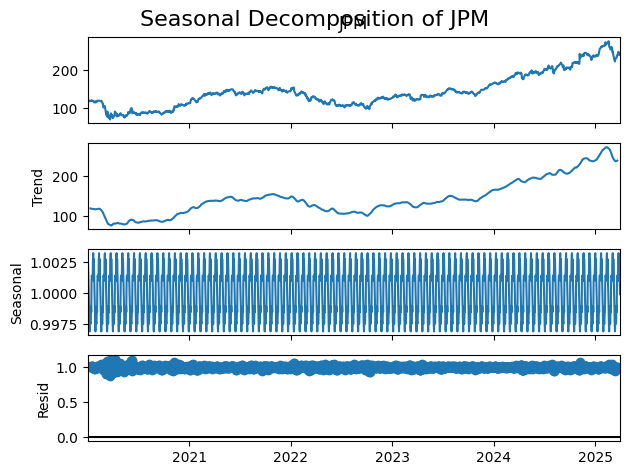

In [74]:
# Decompose stock price of JPM
decomposition = decompose_stock_prices('JPM')

In [75]:
# Split the decomposed data into trend, seasonal, and residual components
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

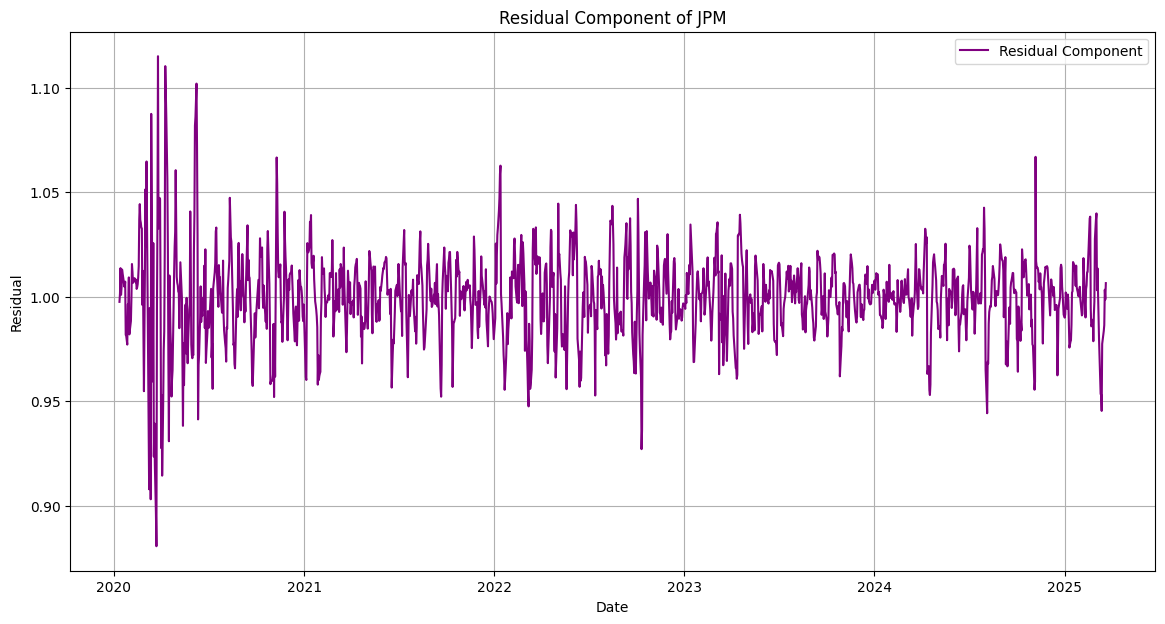

In [76]:
# Plot last 100 days of residual component
plt.figure(figsize=(14, 7))
plt.plot(residual, label='Residual Component', color='purple')
plt.title('Residual Component of JPM')
plt.xlabel('Date')
plt.ylabel('Residual')
plt.legend()
plt.grid()
plt.show()

# Stationarity Check

In [77]:
# ADF test for stationarity
def adf_test(stock_symbol):
    stock_data = df_complete_alldays['Close'][stock_symbol].dropna()
    result = adfuller(stock_data)
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'   {key}: {value}')
    if result[1] <= 0.05:
        print(f'The time series {stock_symbol} is stationary.')
    else:
        print(f'The time series {stock_symbol} is non-stationary.')

In [80]:
# ADF test for JPM
adf_test('JPM')

ADF Statistic: 0.0066550436221734935
p-value: 0.9590790052916175
Critical Values:
   1%: -3.4337855345177255
   5%: -2.863057593089076
   10%: -2.56757790858712
The time series JPM is non-stationary.


In [81]:
residual.dropna(inplace=True)

In [82]:
# ADF test on residual component
result = adfuller(residual)
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
print('Critical Values:')
for key, value in result[4].items():
    print(f'   {key}: {value}')
if result[1] <= 0.05:
    print(f'The time series redsidual is stationary.')
else:
    print(f'The time series redsidual is non-stationary.')

ADF Statistic: -12.848906628682473
p-value: 5.4053575175514226e-24
Critical Values:
   1%: -3.433849890092939
   5%: -2.863086004488984
   10%: -2.567593036523882
The time series redsidual is stationary.


# ARIMA Model for Forecasting

# Residual Analysis

#  Forecasting and Visualization